In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from dateutil.parser import parse
import datetime
from dateutil.parser import parse
import math
from numpy import mean

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline as SKLpipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from dtreeviz.trees import dtreeviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBLpipeline

from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 30)

In [2]:
# read df pickle
df_alg = pd.read_pickle("objects/df_alg-HAB_preprocessing_5_1")
# data = pd.read_pickle("data/preprocessed/hab_org-data-HAB_part2-preprocessing-5_2")
data = pd.read_pickle("data/preprocessed/hab_interp_data-HAB_part2-preprocessing-5_2")

data.drop(columns=["sampling station", "date"], inplace=True)
# data.set_index('date', inplace=True)


# slice by station and time
# data = data[data["sampling station"] == "Debeli_rtic"].loc["2008-01-01" : "2021-12-31"]

data.isnull().sum()

DSP                        1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    422
salinity                  21
T                         59
SECCHI                   450
DIN                      352
PO4-P                    349
Soca                       0
month                      0
lipophylic_toxins        320
dtype: int64

In [3]:
# Class distribution
data["lipophylic_toxins"].value_counts(dropna=False)

neg    996
NaN    320
poz    136
Name: lipophylic_toxins, dtype: int64

In [4]:
# data.drop(columns=["Chl-a","PO4-P","DIN","SECCHI"], inplace=True)
data.drop(columns=["SECCHI",  ], inplace=True)#,"Chl-a", "PO4-P", "DIN",
data.isnull().sum()

DSP                        1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    422
salinity                  21
T                         59
DIN                      352
PO4-P                    349
Soca                       0
month                      0
lipophylic_toxins        320
dtype: int64

# Modelling and Preliminary Results

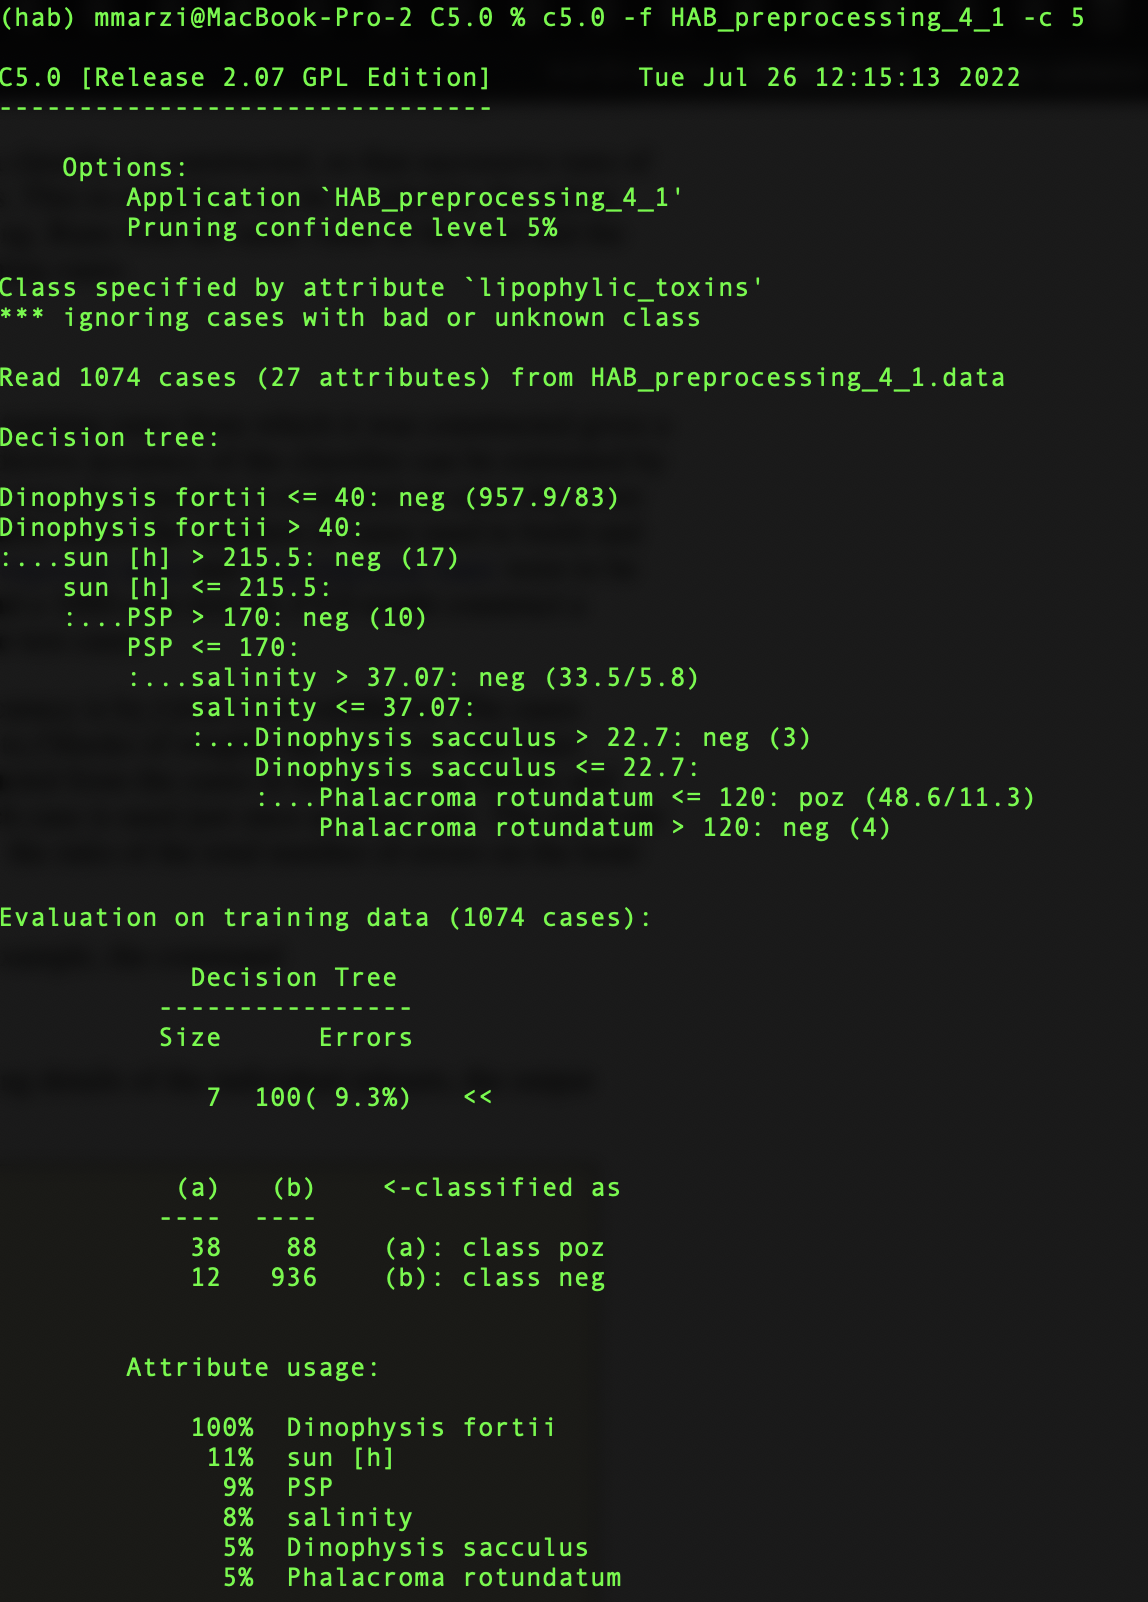

# Scikit-learn Analysis

### Preprocessing

In [5]:
# Prepare for ML in scikit-learn
# labeled and unlabeled part
data_l = data[data['lipophylic_toxins'].notnull()]
data_ul = data[data['lipophylic_toxins'].isnull()]

# Remove missing values
data_l = data_l.dropna(how="any")
print(f"class distribution:")
print(data_l["lipophylic_toxins"].value_counts(dropna=False))

X = data_l.drop("lipophylic_toxins", axis=1)
y = data_l["lipophylic_toxins"]

# sklearn lable encoding
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(f"class encoding: ['neg','poz'] -> {le.transform(['neg','poz'])}")

class distribution:
neg    662
poz     88
Name: lipophylic_toxins, dtype: int64
class encoding: ['neg','poz'] -> [0 1]


Clean the dataset by removing samples close to the decision boundary. Because the dataset is heavily imbalanced in favor of clas 0 (neg) we will remove instances from this class whenever finding samples which do not agree “enough” with their neighboorhood. The EditedNearestNeighbours will be used. One other option is to use Tomek links but it is more conservative and was found to perform slightly worse.

In [6]:
from collections import Counter
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours

print(f'Original dataset shape: {Counter(y)}')
usmp = EditedNearestNeighbours()
lastMajorityCount = Counter(y)[0]
for i in range(10):
    X_res, y_res = usmp.fit_resample(X, y)
    if Counter(y_res)[0] == lastMajorityCount:
        print('Cannot remove any more samples')
        break
    else:
        print(f'Resampled dataset shape {Counter(y_res)}')
        lastMajorityCount = Counter(y_res)[0]
    X = X_res
    y = y_res

Original dataset shape: Counter({0: 662, 1: 88})
Resampled dataset shape Counter({0: 540, 1: 88})
Resampled dataset shape Counter({0: 501, 1: 88})
Resampled dataset shape Counter({0: 490, 1: 88})
Resampled dataset shape Counter({0: 488, 1: 88})
Resampled dataset shape Counter({0: 487, 1: 88})
Cannot remove any more samples


## Model Training and Evaluation

### Decision Tree Model (sklearn)

In [7]:
pd.set_option("display.max_rows", None)

pipeline = IMBLpipeline([
    ('smt', SMOTE()), 
    ('under', RandomUnderSampler()), 
    ('clf', DecisionTreeClassifier())
])

parameters = {
            'clf__max_depth': [2,3,4],
            'clf__criterion': ['gini', 'entropy', 'log_loss'],
               'clf__class_weight': ['balanced', None],
               'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
               'under__sampling_strategy': [0.5, 0.6, 0.7],
               'smt__k_neighbors': [1, 3, 5]
             }
nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc', 'recall_weighted']
gscv = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    return_train_score=False, 
                    verbose=1, 
                    refit="recall",
                    n_jobs=-1)
resultsGSCV = gscv.fit(X, y)
results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_recall']).transpose())

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


,19,122,119,189,56,194,209,117,208,210,32,152,191,190,22,...,363,468,420,451,437,330,249,332,439,358,327,433,360,414,417
mean_fit_time,0.020395,0.0217,0.020607,0.019288,0.020125,0.021806,0.018885,0.019663,0.019584,0.019975,0.01969,0.021892,0.021484,0.02015,0.019377,...,0.02157,0.01938,0.020226,0.020029,0.021426,0.019909,0.019191,0.019365,0.02031,0.020364,0.020205,0.018769,0.020165,0.018843,0.02026
std_fit_time,0.002047,0.001509,0.001456,0.001272,0.001174,0.002405,0.000538,0.000602,0.001088,0.001963,0.001367,0.000796,0.002605,0.001864,0.000653,...,0.002202,0.000595,0.000992,0.002342,0.001404,0.000451,0.000608,0.000935,0.001266,0.00074,0.002241,0.000308,0.002765,0.000481,0.0008
mean_score_time,0.009514,0.009245,0.009679,0.010545,0.009549,0.010234,0.010022,0.009854,0.011142,0.009463,0.01012,0.010257,0.009641,0.009432,0.009468,...,0.010036,0.009325,0.010345,0.009477,0.009953,0.009584,0.009855,0.009409,0.009959,0.009342,0.009907,0.009271,0.010298,0.009461,0.009645
std_score_time,0.001335,0.000542,0.000349,0.001773,0.000482,0.001478,0.000398,0.000258,0.002915,0.000482,0.002925,0.001035,0.000229,0.000943,0.000398,...,0.00081,0.00027,0.001006,0.000547,0.000285,0.000261,0.000343,0.000064,0.001475,0.000773,0.000447,0.000366,0.003254,0.000171,0.000214
param_clf__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
param_clf__criterion,gini,entropy,entropy,log_loss,gini,log_loss,log_loss,entropy,log_loss,log_loss,gini,entropy,log_loss,log_loss,gini,...,entropy,log_loss,log_loss,log_loss,log_loss,entropy,gini,entropy,log_loss,entropy,entropy,log_loss,entropy,log_loss,log_loss
param_clf__max_depth,2,3,3,3,4,3,3,3,3,3,3,4,3,3,2,...,3,4,2,3,3,2,2,2,3,3,2,3,3,2,2
param_smt__k_neighbors,5,3,3,1,1,1,5,3,5,5,1,3,1,1,5,...,3,3,3,5,1,1,1,1,1,1,1,1,3,3,3
param_smt__sampling_strategy,0.2,0.3,0.2,0.2,0.2,0.3,0.2,0.2,0.2,0.3,0.3,0.4,0.2,0.2,0.3,...,0.3,0.2,0.4,0.2,0.3,0.4,0.4,0.4,0.4,0.4,0.3,0.2,0.2,0.2,0.3
param_under__sampling_strategy,0.6,0.7,0.7,0.5,0.7,0.7,0.7,0.5,0.6,0.5,0.7,0.7,0.7,0.6,0.6,...,0.5,0.5,0.5,0.6,0.7,0.5,0.5,0.7,0.6,0.6,0.5,0.6,0.5,0.5,0.5


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


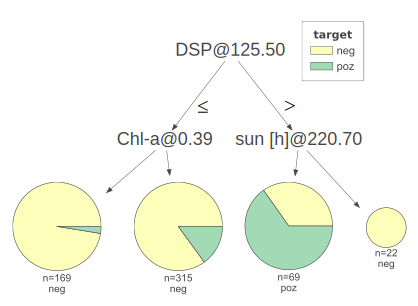

In [8]:
clf = gscv.best_estimator_.steps[2][1]
viz = dtreeviz(clf, X, y,
                target_name="target",
                feature_names=X.columns,
                class_names=["neg", "poz"],
             fancy=False,
               scale=1.5
              )

viz

### Random Forest Model

#### Model evaluation (Random Forest)

In [9]:
# Random forest with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
   ('smt', SMOTE()), 
   ('under', RandomUnderSampler()), 
    ('clf', RandomForestClassifier())
])

parameters = {
              'clf__n_estimators': [100,300,500],
              'clf__criterion': ['gini', 'entropy', 'log_loss'],
              'clf__class_weight': ['balanced', 'balanced_subsample', None],
              'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
              'under__sampling_strategy': [0.5, 0.6, 0.7],
              'smt__k_neighbors': [3, 5]
             }

nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc']
refit_score = 'f1'
gscv = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    return_train_score=False, 
                    verbose=1, 
                    refit=refit_score,
                    n_jobs=-1)
resultsGSCV = gscv.fit(X, y)
results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_recall']).transpose())
pd.set_option("display.max_rows", None)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


,479,389,371,140,335,344,191,101,137,146,415,419,263,86,425,...,165,384,39,276,285,6,111,61,24,177,60,168,12,186,33
mean_fit_time,1.406045,0.289884,1.371338,0.947765,0.294524,0.820654,1.029259,1.462493,0.869626,1.422397,1.454762,1.757425,1.721905,0.913961,1.476861,...,0.403438,0.364982,1.451366,0.452975,0.430067,0.299388,0.332391,0.359688,0.865517,0.423514,0.374456,0.436323,0.292571,1.216978,0.957486
std_fit_time,0.020526,0.002739,0.033996,0.013556,0.009113,0.009442,0.01447,0.032562,0.010225,0.012693,0.019319,0.021834,0.014986,0.010964,0.027229,...,0.00335,0.004446,0.0072,0.008915,0.002445,0.014987,0.001475,0.004265,0.002542,0.003891,0.00957,0.004453,0.004025,0.013923,0.011928
mean_score_time,0.217757,0.052796,0.228998,0.145459,0.054564,0.138915,0.148998,0.243501,0.144714,0.226055,0.24816,0.248231,0.225068,0.137944,0.22118,...,0.061487,0.052473,0.21434,0.053716,0.053479,0.05254,0.054329,0.053406,0.120092,0.056361,0.054482,0.058539,0.054166,0.147352,0.137262
std_score_time,0.004889,0.001679,0.00253,0.0102,0.002839,0.001972,0.006352,0.018727,0.001211,0.003865,0.02854,0.016414,0.013763,0.003742,0.004602,...,0.001652,0.000729,0.005005,0.00384,0.000767,0.004007,0.002194,0.001238,0.002033,0.002679,0.003353,0.001751,0.002267,0.002749,0.005958
param_clf__class_weight,None,None,None,balanced,None,None,balanced_subsample,balanced,balanced,balanced,None,None,balanced_subsample,balanced,None,...,balanced_subsample,None,balanced,balanced_subsample,balanced_subsample,balanced,balanced,balanced,balanced,balanced_subsample,balanced,balanced_subsample,balanced,balanced_subsample,balanced
param_clf__criterion,log_loss,entropy,gini,log_loss,gini,gini,gini,entropy,log_loss,log_loss,entropy,entropy,entropy,entropy,entropy,...,gini,entropy,gini,log_loss,log_loss,gini,log_loss,entropy,gini,gini,entropy,gini,gini,gini,gini
param_clf__n_estimators,500,100,500,300,100,300,300,500,300,500,500,500,500,300,500,...,100,100,500,100,100,100,100,100,300,100,100,100,100,300,300
param_smt__k_neighbors,5,5,5,5,5,3,5,5,5,3,3,3,5,5,5,...,3,3,3,3,5,3,3,3,3,5,3,3,5,3,5
param_smt__sampling_strategy,0.2,0.2,0.2,0.3,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.3,0.2,0.3,0.2,...,0.3,0.4,0.3,0.4,0.4,0.4,0.3,0.4,0.4,0.4,0.4,0.4,0.3,0.4,0.4
param_under__sampling_strategy,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.7,0.7,0.7,0.7,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.5,0.5,0.5,0.5,0.5,0.5,0.5


Plot the mean ROC curve of the algorithm with best performing parameter selection. We will perform CV once again and plot the ROC curve for each fold and compute and plot the mean.

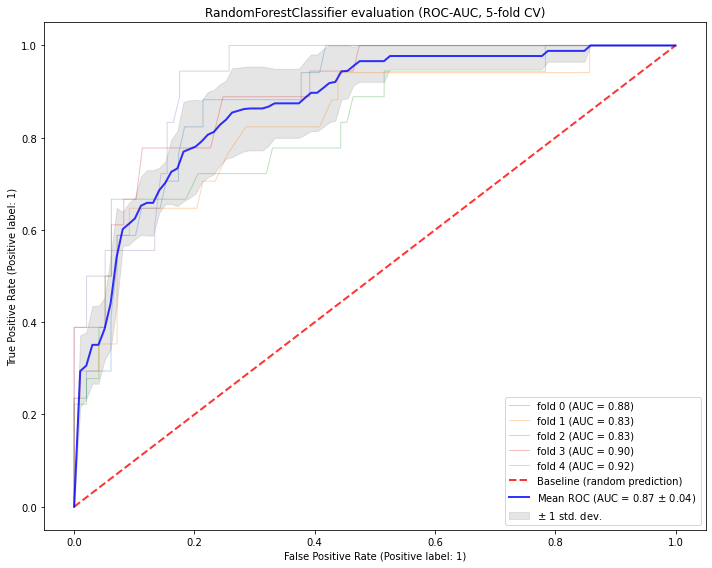

In [10]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=nfolds, shuffle=True)
classifier = resultsGSCV.best_estimator_

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Baseline (random prediction)", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (ROC-AUC, {nfolds}-fold CV)',
)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

Plot the mean precision-recall curve. The approach is the same as for the mean ROC curve.

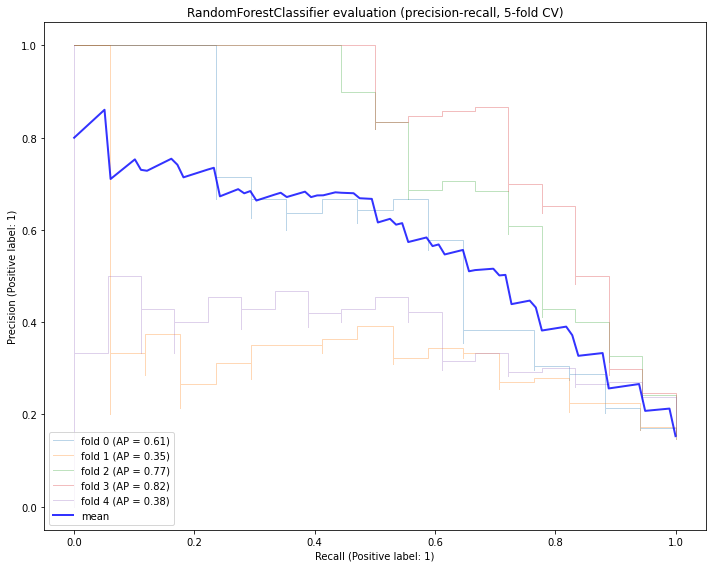

In [11]:
from sklearn.metrics import PrecisionRecallDisplay

cv = StratifiedKFold(n_splits=nfolds, shuffle=True)
classifier = resultsGSCV.best_estimator_

prs = []
aucs = []
mean_r = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_pr = np.interp(mean_r, viz.recall[::-1], viz.precision[::-1])
    prs.append(interp_pr)

mean_p = np.mean(prs, axis=0)
ax.plot(
    mean_r,
    mean_p,
    color="b",
    label=f"mean",
    lw=2,
    alpha=0.8,
)
ax.legend(loc="lower left")
clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    # xlim=[-0.05, 1.05],
    # ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (precision-recall, {nfolds}-fold CV)')
plt.tight_layout()
plt.show()

#### Feature importance (Random Forest)

Text(0.5, 1.0, 'Permutation Importance Random Forest')

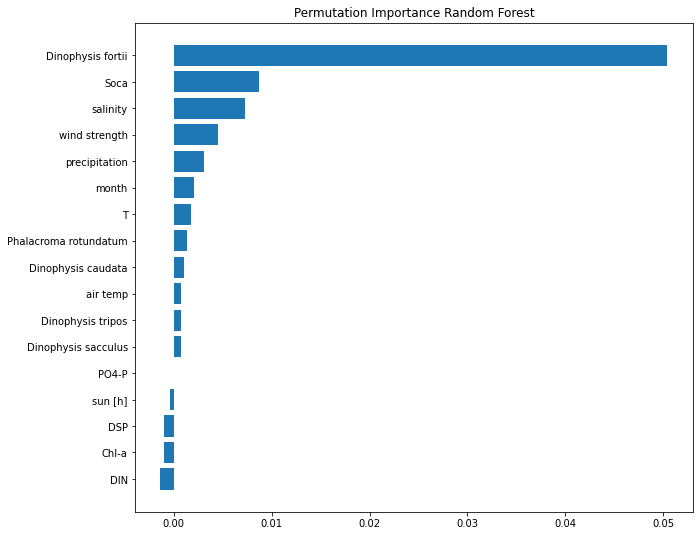

In [12]:
# Feature importance of model (best RandomForest from gridsearch) with three methods!

fig, (ax2) = plt.subplots(1, 1, figsize=(10,9))
plt.subplots_adjust(wspace=1.1)

rf = gscv.best_estimator_.steps[2][1]

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(rf, X, y)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance Random Forest")

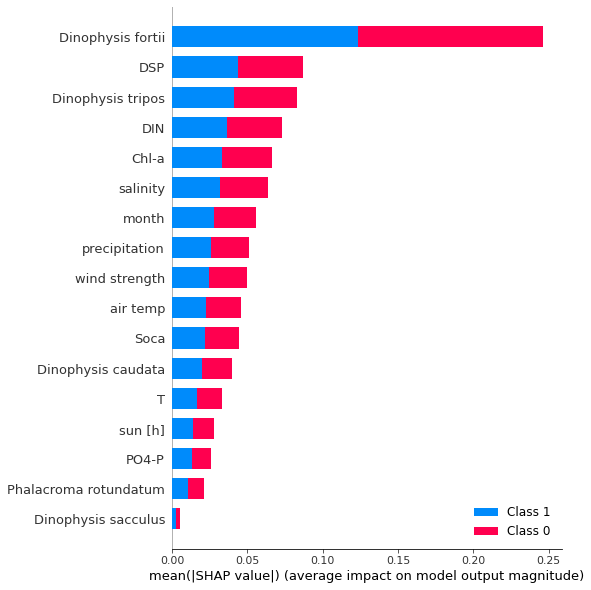

In [13]:
# Get feature importance with SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
RF_shap = shap.summary_plot(shap_values, X, plot_type="bar")

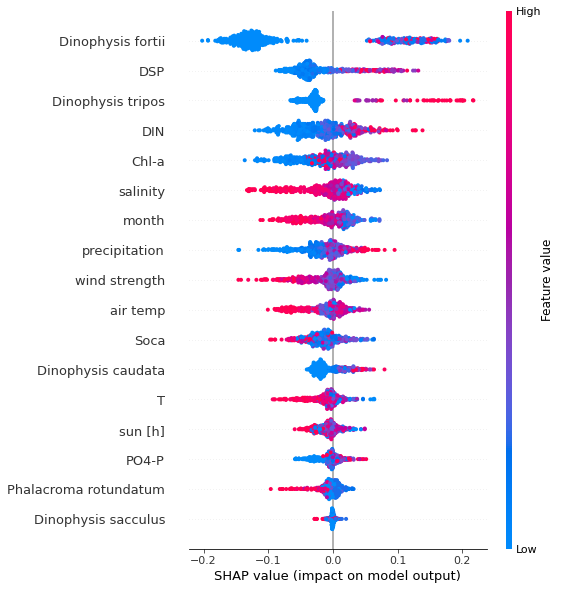

In [14]:
# SHAP summary plot
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
classid = 1
shap.summary_plot(shap_values[classid], X, max_display=len(X.columns), class_names=le.classes_)

### Neural Network Model

#### Model Evaluation (MLP)

In [15]:
# Preprocessing for NN in scikit_learn

# Model evaluation with the pipeline of SMOTE oversampling and undersampling on the training dataset only (within each cross-validation fold)!

# one-hot encoding of month feature
Xohe = pd.get_dummies(X, columns=["month"])

X_display = Xohe.copy()  # *used for SHAP visualization so we can show unscaled values

# scalling numeric values for NN
scaled_array = StandardScaler().fit_transform(Xohe)
Xsc = pd.DataFrame(scaled_array, columns=Xohe.columns)

In [16]:
# pd.set_option("display.max_rows", None)

In [17]:
# MLP with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
    ('over', SMOTE()),
    ('under', RandomUnderSampler()),
    ('clf', MLPClassifier(solver='lbfgs', max_iter=5000))
])

parameters = {'over__k_neighbors': range(1,7),
              'over__sampling_strategy': [0.4, 0.5, 0.6],
              'under__sampling_strategy': [0.6, 0.7, 0.8],
              'clf__hidden_layer_sizes': [(2, ), (2, 2), (3,), (3,3)],
             }
nfolds = 5
scores = ['recall', "precision", 'f1', 'roc_auc']
gscv = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    n_jobs= -1, 
                    return_train_score=False, 
                    verbose=1, 
                    refit= "recall")
resultsGSCV = gscv.fit(Xsc, y)
results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_recall']).transpose())

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,92,84,106,136,11,47,128,154,165,75,110,137,68,155,10,...,159,115,70,72,100,96,36,97,79,98,95,73,69,14,61
mean_fit_time,0.486924,0.391317,0.368836,0.235095,0.280381,0.286248,0.289294,0.348677,0.341616,0.591188,0.2621,0.149912,0.40316,0.317424,0.360976,...,0.753237,0.405361,0.311562,0.301302,0.270675,0.354498,0.385585,0.281597,0.345815,0.277915,0.278253,0.273641,0.733869,0.419105,0.245455
std_fit_time,0.31522,0.135934,0.135333,0.130634,0.106057,0.094,0.117651,0.120908,0.156117,0.333911,0.136038,0.038719,0.130538,0.171321,0.34142,...,0.690448,0.349359,0.153474,0.140714,0.110263,0.101913,0.112135,0.187198,0.217406,0.215949,0.151728,0.122066,0.604083,0.239508,0.124413
mean_score_time,0.012635,0.01383,0.012193,0.011461,0.0104,0.013143,0.010865,0.012188,0.011301,0.015071,0.01183,0.011935,0.014413,0.011704,0.010794,...,0.012626,0.011422,0.014155,0.013871,0.012896,0.012909,0.010827,0.013206,0.013381,0.012413,0.012702,0.013845,0.018144,0.01094,0.014103
std_score_time,0.000484,0.001094,0.000422,0.000281,0.000445,0.003948,0.001732,0.001227,0.000218,0.00323,0.002098,0.001096,0.001311,0.00052,0.000159,...,0.002425,0.001297,0.000982,0.000964,0.000935,0.001184,0.000059,0.000972,0.000348,0.000587,0.000398,0.000952,0.005672,0.000353,0.001262
param_clf__hidden_layer_sizes,"(2, 2)","(2, 2)","(2, 2)","(3,)","(2,)","(2,)","(3,)","(3,)","(3, 3)","(2, 2)","(3,)","(3,)","(2, 2)","(3,)","(2,)",...,"(3,)","(3,)","(2, 2)","(2, 2)","(2, 2)","(2, 2)","(2,)","(2, 2)","(2, 2)","(2, 2)","(2, 2)","(2, 2)","(2, 2)","(2,)","(2, 2)"
param_over__k_neighbors,5,4,6,4,2,6,3,6,1,3,1,4,2,6,2,...,6,1,2,3,6,5,5,5,3,5,5,3,2,2,1
param_over__sampling_strategy,0.4,0.5,0.6,0.4,0.4,0.4,0.4,0.4,0.5,0.5,0.4,0.4,0.5,0.4,0.4,...,0.6,0.6,0.6,0.4,0.4,0.6,0.4,0.6,0.6,0.6,0.5,0.4,0.6,0.5,0.6
param_under__sampling_strategy,0.8,0.6,0.7,0.7,0.8,0.8,0.8,0.7,0.6,0.6,0.8,0.8,0.8,0.8,0.7,...,0.6,0.7,0.7,0.6,0.7,0.6,0.6,0.7,0.7,0.8,0.8,0.7,0.6,0.8,0.7
params,"{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (3,), 'over__k_nei...","{'clf__hidden_layer_sizes': (2,), 'over__k_nei...","{'clf__hidden_layer_sizes': (2,), 'over__k_nei...","{'clf__hidden_layer_sizes': (3,), 'over__k_nei...","{'clf__hidden_layer_sizes': (3,), 'over__k_nei...","{'clf__hidden_layer_sizes': (3, 3), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (3,), 'over__k_nei...","{'clf__hidden_layer_sizes': (3,), 'over__k_nei...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (3,), 'over__k_nei...","{'clf__hidden_layer_sizes': (2,), 'over__k_nei...",...,"{'clf__hidden_layer_sizes': (3,), 'over__k_nei...","{'clf__hidden_layer_sizes': (3,), 'over__k_nei...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2,), 'over__k_nei...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n...","{'clf__hidden_layer_sizes': (2,), 'over__k_nei...","{'clf__hidden_layer_sizes': (2, 2), 'over__k_n..."
split0_test_recall,0.588235,0.705882,0.529412,0.705882,0.470588,0.647059,0.588235,0.647059,0.588235,0.647059,0.588235,0.647059,0.470588,0.529412,0.588235,...,0.352941,0.352941,0.588235,0.588235,0.588235,0.176471,0.470588,0.647059,0.0,0.647059,0.352941,0.470588,0.411765,0.411765,0.647059


#### Feature Importance (MLP)

Text(0.5, 1.0, 'Permutation Importance MLP')

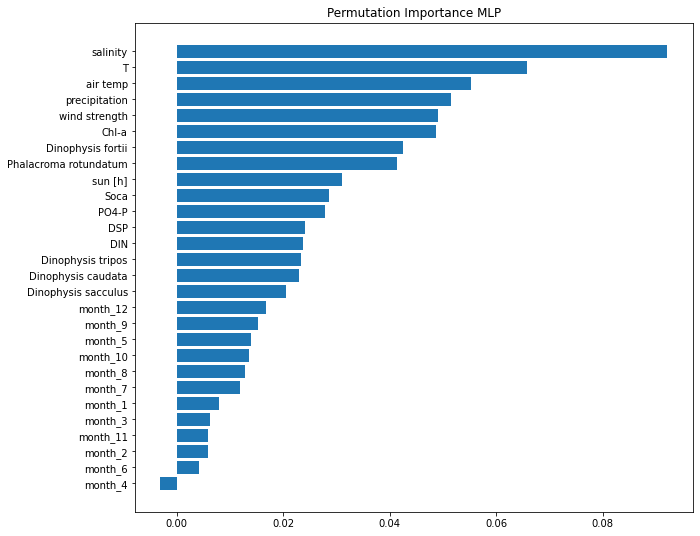

In [18]:
# Feature importance of model (MLP)  (no cross-validation!)

fig, (ax2) = plt.subplots(1, 1, figsize=(10,9))
plt.subplots_adjust(wspace=3)

MLP = gscv.best_estimator_.steps[2][1]

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(MLP, Xsc, y)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = Xsc.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance MLP")

#### Feature importance with SHAP

In [19]:
X = Xsc.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.25)

nn = MLPClassifier(hidden_layer_sizes=(3,3), solver='lbfgs', max_iter=5000)
model = nn.fit(X_train.to_numpy(), y_train)

First, visualize the impact of all features on both classes in one chart. We are using KernelExplainer but simpler general Explainer should be also tested once the SHAP code fixes all bugs.

**Note: SHAP explanations change between runs because of sampling and probably other random factors!**

  0%|          | 0/144 [00:00<?, ?it/s]

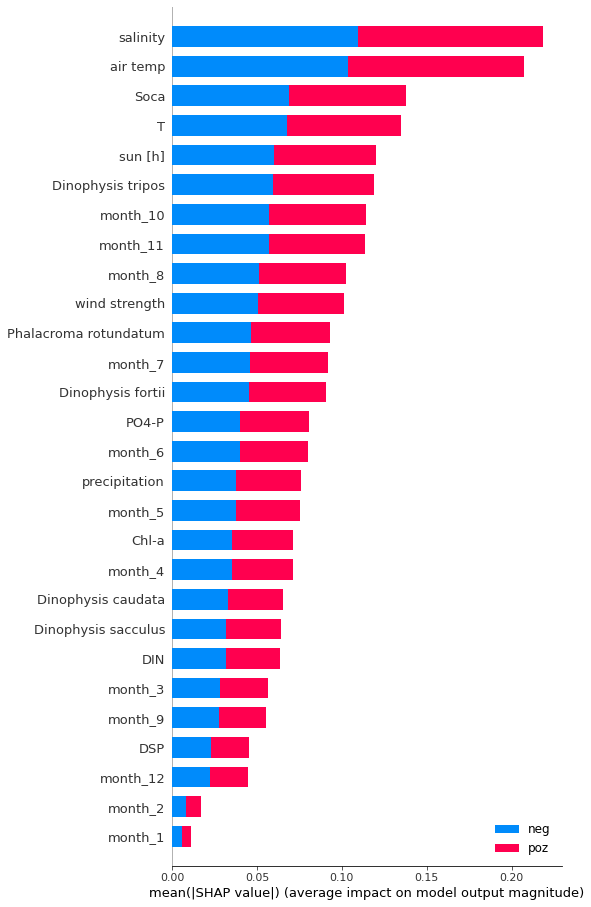

In [20]:
# explain the model's predictions using SHAP
import shap
import warnings
warnings.filterwarnings("ignore")
shap.initjs()

explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_test,20))
shap_values = explainer.shap_values(X_test, nsamples=50)
shap.summary_plot(shap_values, X_test, max_display=len(X.columns), class_names=le.classes_)

Now for each class separately. We observe the impact of features on the returned model's probability for a given class.

  0%|          | 0/144 [00:00<?, ?it/s]

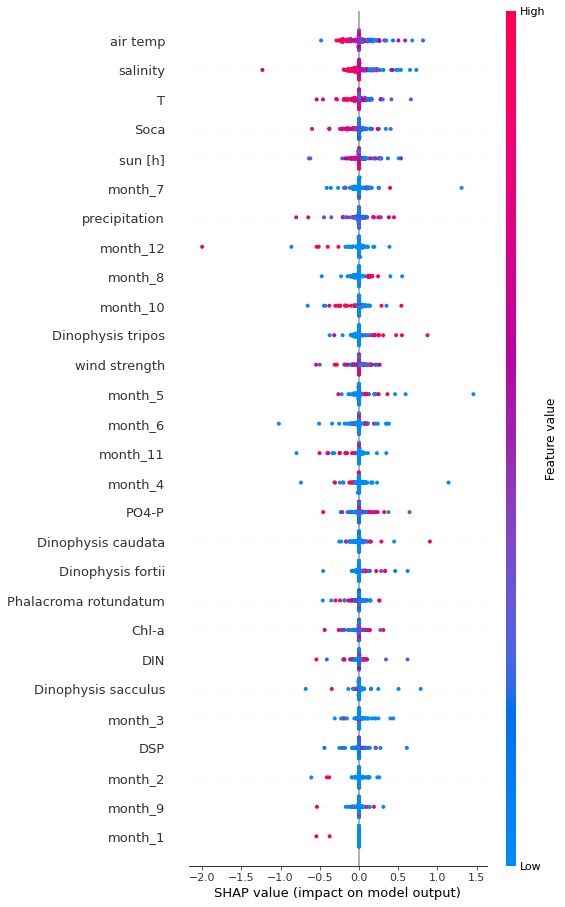

In [21]:
explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_test,50))
shap_values = explainer.shap_values(X_test, nsamples=50)
classid = 1
shap.summary_plot(shap_values[classid], X_test, max_display=len(X.columns), class_names=le.classes_)

  0%|          | 0/144 [00:00<?, ?it/s]

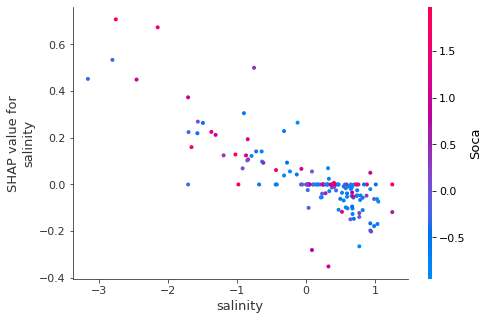

In [22]:
# Try dependence contribution plot
explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_test,50))
shap_values = explainer.shap_values(X_test, nsamples=50)
shap.dependence_plot('salinity', shap_values[1], X_test,) #interaction_index="salinity"

Example intepretation: The fact this slopes upward says the higher the soca flow, the higher the model's prediction is for poz/neg. The spread suggests that other features must interact with Soca flow. 
In general, high Soca flow increases the chance of poz/neg. But if the sea temp is moderate or low, that trend reverses and even high soca flow does not increase preditions of poz/neg as the sea temp is too low.
https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values

Now let's explain the prediction of a single instance. We will show the explanation of the bigger predicted probability to see why the model decided as it did. But in practice we could be interested only in the explanation of the probability of the positive prediction.

In [23]:
instanceID = 10
instance = X.iloc[[instanceID]]
display_instance = X_display.iloc[[instanceID]]

prediction = model.predict(instance)[0]
prediction_probs = model.predict_proba(instance)[0]
print(f'real value: {y[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X, 50))
shap_values = explainer.shap_values(instance, nsamples=500)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

real value: 0, 
predicted: 0, 
predicted probs: [1.00000000e+00 2.43465291e-11]
Explanation for prediction: class=0, p=0.9999999999756535


  0%|          | 0/1 [00:00<?, ?it/s]

Show the mean values of features as it may help understanding this particular instance data in the plot above.

In [24]:
data = pd.get_dummies(data, columns=["month"])


pd.DataFrame([data[data['lipophylic_toxins']=='neg'].mean(), data[data['lipophylic_toxins']=='poz'].mean()], index=['neg','pos']).T

,neg,pos
DSP,102.700503,195.860294
Dinophysis caudata,25.537688,40.543382
Dinophysis fortii,23.725829,72.827941
Phalacroma rotundatum,16.438492,13.510294
Dinophysis sacculus,24.474070,52.823529
Dinophysis tripos,4.902513,8.235294
sun [h],165.661647,152.191912
air temp,17.422122,16.944328
wind strength,2.997017,2.921674
precipitation,56.557731,75.321324


### Conclusion

In [25]:
# Summary table of prediction results
RF_recall = round(RF_recall_best_k[1], 2)
RF_auc = round(RF_auc_best_k[1], 2)
MLP_recall = round(MLP_recall_best_k[1], 2)
MLP_auc = round(MLP_auc_best_k[1], 2)

summary = pd.DataFrame(
    [
        (
            "RF",
            RF_recall_score,
            RF_auc_score,
        ),
        (
            "MLP",
            MLP_recall_score,
            MLP_auc_score,
        ),
        (
            "RF (smote)",
            RF_recall,
            RF_auc,
        ),
        (
            "MLP (smote)",
            MLP_recall,
            MLP_auc,
        ),
        (
            "Decision tree (J48)*",
            0.56,
            0.18,
        ),
    ],
    columns=("Model", "Recall", "ROC AUC"),
).set_index("Model")

print("Table summarising the prediction results of the used classifiers, both with and without SMOTE resampling:\n")
summary.round(2)

NameError: name 'RF_recall_best_k' is not defined

As can be seen resampling with SMOTE helped to improve the results substantially, especially when calculating recall. The highest recall and ROC AUC was achieved with Random Forest with the re-sampled data. Both recall and ROC AUC suggest Random Forest as beeing the better classifier for this particular problem. Recall is a crucial metric as it gives indication of what fraction of true positive instances have been predicted. Since the models predict toxins in seashells (food) it is crucial that as few positives as possible are missed.

Due to the use of SMOTE resampling (upsampling and downsampling) in combinaiton with cross-validation it was curcial to do the resampling within each fold to avoid data lekeage and validate on original (unsampled) data. In addition, I have optimised the model with regard to the k-values of SMOTE, all of which brought along some complexity. So for the parameter tuning of Random Forest and MLP various parameter settings have been tried  and the model with best performing settings has been chosen.

The decision tree J48 algorithm was run within Weka on a slightly different dataset (missing values were not removed to use as many instances as possible, cross validation was 10-fold as opposed to 3-fold due to a higher dataset etc.) thus this results are not directly comparable but were provided as a reference to give an indication of the performance of this algorithm. 

As can be seen in the feature importance bar plots above, similar features were on the top despite using two different classification algorithms and two different feature ranking methods. If we consider just the three highest-ranking features of each of the feature ranking methods for both algortihms (RF and MLP) the features that overlap are DSP, DSP_like, ASP, Dinophysis fortii and Dinophysis caudata. These can be shown to the domain experts for validation and interpretation.